# A Simple Guide of CoolBox


In [1]:
% matplotlib inline

# import packages
from coolbox.api import *

## Data preparation
### Download some example files

Firstly we download some example genomic data from public database. Here, all of our data is about the K562 cancer cell line.

In [1]:
%%bash

mkdir data

# example .cool file
wget -O data/K562_MbolI_5kb.cool ftp://cooler.csail.mit.edu/coolers/hg19/Rao2014-K562-MboI-allreps-filtered.5kb.cool
# .looplist file
wget -O data/K562_MbolI_looplist.txt.gz ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63525/suppl/GSE63525_K562_HiCCUPS_looplist.txt.gz

# bigwig files (ChIP-Seq and RNA-Seq data)
wget -O data/K562_H3K27ac.bigWig  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM733nnn/GSM733656/suppl/GSM733656_hg19_wgEncodeBroadHistoneK562H3k27acStdSig.bigWig
wget -O data/K562_H3K27me3.bigWig ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM733nnn/GSM733658/suppl/GSM733658_hg19_wgEncodeBroadHistoneK562H3k27me3StdSig.bigWig
wget -O data/K562_H3K4me3.bigWig  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM945nnn/GSM945297/suppl/GSM945297_hg19_wgEncodeUwHistoneK562H3k04me3StdZnf2c10c5RawRep1.bigWig
wget -O data/K562_RNASeq.bigWig ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM765nnn/GSM765393/suppl/GSM765393_wgEncodeCshlLongRnaSeqK562NucleolusTotalMinusRawSigRep4.bigWig
# ChIA-PET data
wget -O data/K562_chiapet_interaction.txt.gz ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM832nnn/GSM832465/suppl/GSM832465_CHK019M_L2_lane24.ChromatinInteractions.bed.gz
wget -O data/K562_chiapet.bigWig ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM832nnn/GSM832465/suppl/GSM832465_CHK019M_L2_lane24.bw

# RefSeq
wget -O data/refGene.txt.gz http://hgdownload.soe.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
!ls -lh data

total 2.3G
-rw-rw-r-- 1 nanguage nanguage  81M 4月   9 17:32 K562_chiapet.bigWig
-rw-rw-r-- 1 nanguage nanguage 2.0M 4月   9 17:31 K562_chiapet_interaction.txt.gz
-rw-rw-r-- 1 nanguage nanguage 293M 4月   9 16:56 K562_H3K27ac.bigWig
-rw-rw-r-- 1 nanguage nanguage 384M 4月   9 17:13 K562_H3K27me3.bigWig
-rw-rw-r-- 1 nanguage nanguage  83M 4月   9 17:17 K562_H3K4me3.bigWig
-rw-rw-r-- 1 nanguage nanguage 528M 4月   9 16:38 K562_MbolI_5kb.cool
-rw-rw-r-- 1 nanguage nanguage 363K 4月   9 16:53 K562_MbolI_looplist.txt.gz
-rw-rw-r-- 1 nanguage nanguage 926M 4月   9 17:31 K562_RNASeq.bigWig
drwxrwxr-x 2 nanguage nanguage 4.0K 4月  10 19:43 preprocessed
-rw-rw-r-- 1 nanguage nanguage 6.5M 4月   8 21:50 refGene.txt.gz


### Preprocessing

Convert some files to specific format which CoolBox accept. 

In [3]:
!mkdir data/preprocessed

Convert [refGene txt](http://genome.ucsc.edu/cgi-bin/hgTables) to [BED12 format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1):

In [2]:
from coolbox.utilities import refgene_txt_to_bed12

refgene_txt_to_bed12("data/refGene.txt.gz", "data/preprocessed/refGene.bed")

In [6]:
!bedtools sort -i data/preprocessed/refGene.bed > data/preprocessed/refGene.sorted.bed

Convert ChIA-PET interaction txt file to .arc format

In [4]:
!zcat data/K562_chiapet_interaction.txt.gz | head -n 5

chr1	2438340	2439860	chr1:2438340..2439860-chr3:73159930..73161594,4	400	.	2438340	2439860	255,0,0	1	1520	0
chr3	73159930	73161594	chr1:2438340..2439860-chr3:73159930..73161594,4	400	.	73159930	73161594	255,0,0	1	1664	0
chr1	2438360	2439860	chr1:2438360..2439860-chr17:41463653..41465693,3	300	.	2438360	2439860	255,0,0	1	1500	0
chr17	41463653	41465693	chr1:2438360..2439860-chr17:41463653..41465693,3	300	.	41463653	41465693	255,0,0	1	2040	0
chr1	2439840	2441340	chr1:2439840..2441340-chr17:41465699..41467820,3	300	.	2439840	2441340	255,0,0	1	1500	0

gzip: stdout: Broken pipe


## Track is the basic element

In CoolBox ploting system, "Track" is the basic element. If you have used genome browser like [UCSC Genome Browser](https://genome.ucsc.edu/) or [WashU EpiGenome Browser](https://epigenomegateway.wustl.edu/), you will know what it is.

Basically, "Track" is a image what is related to a piece of continuous region on the reference genome. The most common track is the bigWig track, If you have read some papers about epigenomics you must have seen some figures like this:

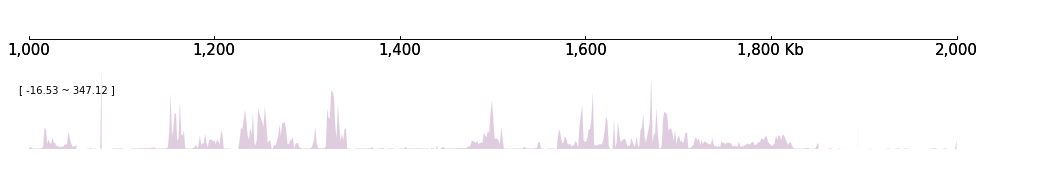

In [18]:
frame = XAxis() + BigWig("data/K562_RNASeq.bigWig")
frame.plot("chr1", 1000000, 2000000)

Actually, bigWig is just one kind of track, there are other kinds of tracks in CoolBox, for display other kind of genomic data like long range genome interaction from ChIA-PET and genome contact matrix from Hi-C.

Now, CoolBox support 8 kinds of tracks:

| Track Type  | CoolBox API | Description | 
| :---------: | :---------: | :---------: |
| XAxis | `coolbox.api.XAxis` | X axis of genome |
| Spacer | `coolbox.api.Spacer` | For add vertical space between two tracks |
| bigWig | `coolbox.api.BigWig` | Track of bigWig file |
| bedgraph | `coolbox.api.BedGraph` | Track of bedgraph file |
| BED | `coolbox.api.Bed` | Track of Bed file, for visualization genome annotation,like refSeq genes chromatin states. |
| TAD | `coolbox.api.TAD` | Track for show TAD(topologically associated domains) |
| Arcs | `coolbox.api.Arcs` | Show the chromosome interactions get from ChIA-PET or Hi-C data. |
| Cool | `coolbox.api.Cool` | Show the chromosome contact matrix from Hi-C data, accept [cooler](https://github.com/mirnylab/cooler) format |

## Interactive visualization by coolbox.Browser

In [2]:
frame = XAxis() + Bed("data/preprocessed/refGene.sorted.bed") + TrackHeight(10)
bsr = Browser(frame)

In [3]:
bsr.show()

VBox(children=(VBox(children=(HBox(children=(Dropdown(options=('chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'), value='chr1'), Button(icon='arrow-left', style=ButtonStyle()), Button(icon='arrow-right', style=ButtonStyle()), Button(icon='search-minus', style=ButtonStyle()), Button(icon='search-plus', style=ButtonStyle()), Text(value='chr1:1-10000000', placeholder="genome range like: 'chr1:10000-20000'"), Button(description='Go', style=ButtonStyle()))), HBox(children=(Label(value='1', layout=Layout(width='2%')), IntRangeSlider(value=(1, 10000000), continuous_update=False, layout=Layout(width='90%'), max=249250621, min=1, readout=False), Label(value='249250621', layout=Layout(width='20%')))), HBox(children=(Checkbox(value=True, description='Auto Range', layout=Layout(width='120px'), style=DescriptionStyle(description_width='initial')), FloatText(value=0.0, description="track's min value:", disabled=True, layout=Layout(width='30%'), step=0.5, style=DescriptionStyle(description_width='initial')), FloatText(value=10.0, description="track's max value:", disabled=True, layout=Layout(width='30%'), step=0.5, style=DescriptionStyle(description_width='initial'))), layout=Layout(justify_content='flex-start'))), layout=Layout(border='solid 2px')), Image(value=b'')))